# Predictive Model on the likelihood of diabetes based on health related features

## About the dataset 
Detailed dataset comprising health and demographic data of 100,000 individuals, aimed at facilitating diabetes-related research and predictive modeling. This dataset includes information on gender, age, location, race, hypertension, heart disease, smoking history, BMI, HbA1c level, blood glucose level, and diabetes status.

### Loading the neccessary packages 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/100000-diabetes-clinical-dataset/diabetes_dataset.csv


In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

rs = 42

In [3]:
data = pd.read_csv('/kaggle/input/100000-diabetes-clinical-dataset/diabetes_dataset.csv')
data.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [4]:
data.shape

(100000, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

The data have 100,000 observations and 16 columns. With no missing data

In [6]:
print(data.duplicated().sum())
data = data.drop_duplicates()
print(data.shape)

14
(99986, 16)


After dropping duplicate observations, we have 99,986 observations left.

I equally renamed the columns be more concised

In [7]:
data.columns

Index(['year', 'gender', 'age', 'location', 'race:AfricanAmerican',
       'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other',
       'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'hbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [8]:
df = data.rename(columns = {'race:AfricanAmerican':'AfricanAmerican',
                           'race:Asian': 'Asian', 'race:Caucasian':'Caucasian',
                           'race:Hispanic': 'Hispanic', 'race:Other':'Others'})
df.head()

,year,gender,age,location,AfricanAmerican,Asian,Caucasian,Hispanic,Others,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


## Exploratory Analysis

From the summary statistics;
* The average age of the individuals recorded in this dataset is approximately 42 years, with 80 being the maximum age
* Average BMI is approximately 27
* Average HbA1c level is 5.5
* Average blood glucose level is 138

In [9]:
numerical_cols = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
data[numerical_cols].describe()

,age,bmi,hbA1c_level,blood_glucose_level
count,99986.000000,99986.000000,99986.000000,99986.000000
mean,41.885930,27.320767,5.527517,138.059518
std,22.516409,6.637248,1.070674,40.708667
min,0.080000,10.010000,3.500000,80.000000
25%,24.000000,23.630000,4.800000,100.000000
50%,43.000000,27.320000,5.800000,140.000000
75%,60.000000,29.580000,6.200000,159.000000
max,80.000000,95.690000,9.000000,300.000000


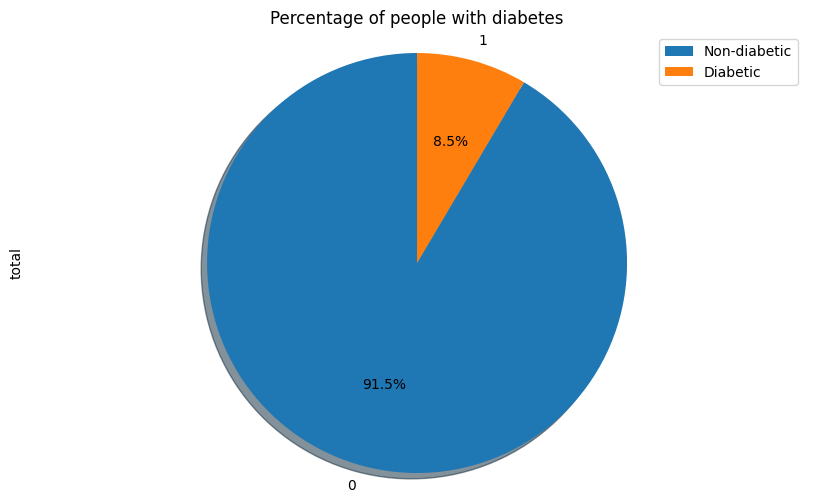

In [10]:
df_dia = df.groupby('diabetes')['gender'].count().reset_index().rename(columns = {'gender': 'total'})
df_dia['total'].plot(kind='pie',
                            figsize=(10, 6),
                            autopct='%1.1f%%',
                            startangle=90,
                            shadow=True,     
                            )
plt.title('Percentage of people with diabetes')
plt.axis('equal')
plt.legend(labels= ['Non-diabetic', 'Diabetic'], loc='upper right')
plt.show()

From the pie chart above, 91.5% of the data do not have diabetes while 8.5% have diabetes

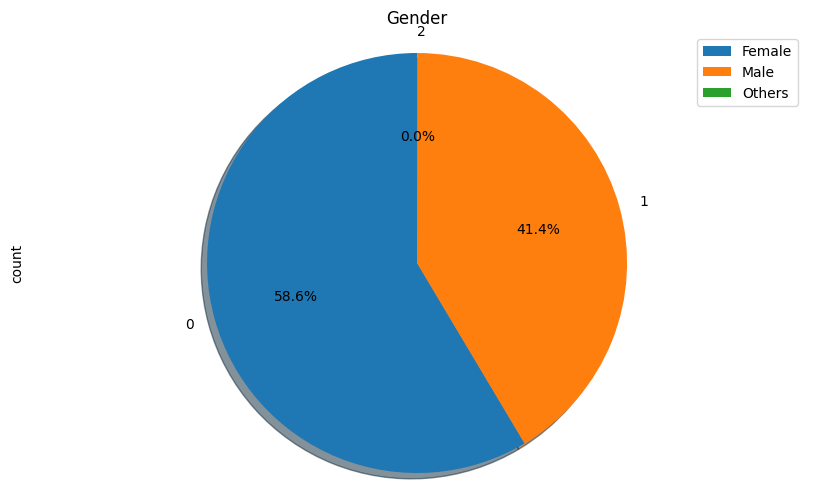

In [11]:
gender = df.groupby('gender')['diabetes'].count().reset_index().rename(columns = {'diabetes': 'count'})
gender['count'].plot(kind = 'pie', 
                    figsize = (10, 6), 
                    autopct = '%1.1f%%',
                    startangle = 90, 
                    shadow = True)
plt.title('Gender')
plt.axis('equal')
plt.legend(['Female', 'Male', 'Others'], loc = 'upper right')
plt.show()

58.6% of the individuals recorded in the data set are females, 41.4% are males while those that identified as others are very insignificant in comparison of with the former.

Out of the 58,552 females in the data set, only 4461 have diabetes. 4,039 out of the 41430 males have diabetes. 18 individuals that identified as 'Other' do not have diabetes

In [12]:
df.groupby(['gender','diabetes'])['bmi'].count().reset_index().rename(columns = {'bmi':'count'})

,gender,diabetes,count
0,Female,0,54085
1,Female,1,4461
2,Male,0,37383
3,Male,1,4039
4,Other,0,18


[]

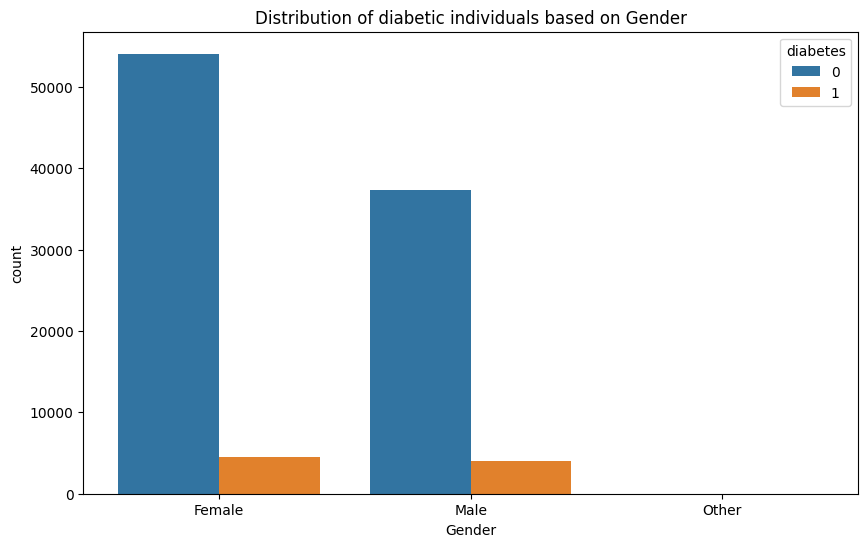

In [13]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'gender', hue = 'diabetes')
plt.title('Distribution of diabetic individuals based on Gender')
plt.xlabel('Gender')
plt.plot()

In [14]:
df.smoking_history.value_counts().reset_index()

,smoking_history,count
0,No Info,35806
1,never,35091
2,former,9352
3,current,9286
4,not current,6447
5,ever,4004


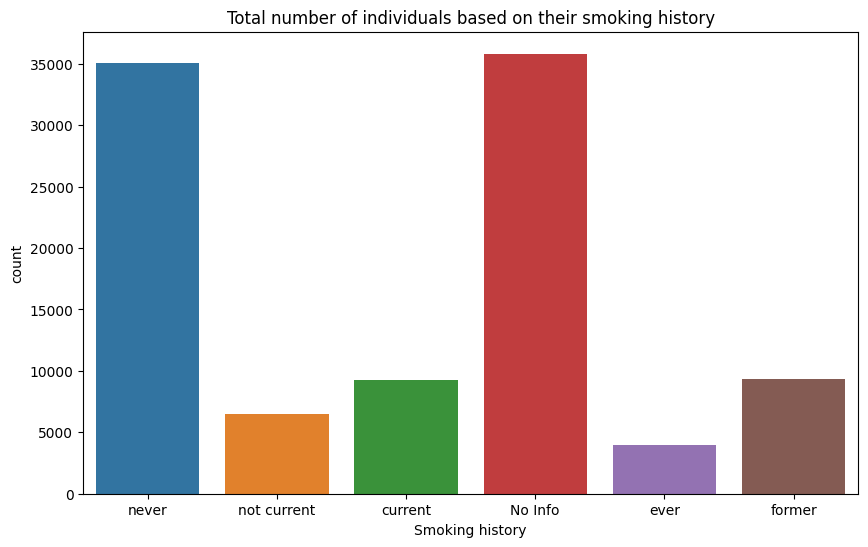

In [15]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'smoking_history')
plt.title('Total number of individuals based on their smoking history')
plt.xlabel('Smoking history')
plt.show()

From the visualization above, the we have more individuals with 'No info' smoking history, followed by those that have 'Never' smoked

In [16]:
df.groupby(['smoking_history','diabetes'])['bmi'].count().reset_index().rename(columns = {'bmi':'total'})

,smoking_history,diabetes,total
0,No Info,0,34352
1,No Info,1,1454
2,current,0,8338
3,current,1,948
4,ever,0,3532
5,ever,1,472
6,former,0,7762
7,former,1,1590
8,never,0,31745
9,never,1,3346


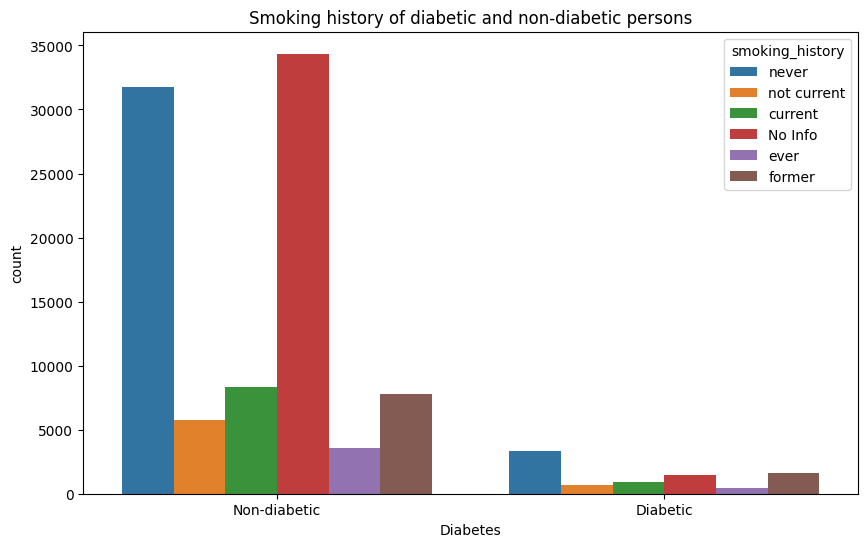

In [17]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'diabetes', hue = 'smoking_history')
plt.title('Smoking history of diabetic and non-diabetic persons')
plt.xlabel('Diabetes')
plt.xticks(ticks = [0, 1], labels = ['Non-diabetic', 'Diabetic'])
plt.show()

There is no discernable pattern in the number of diabetic and non-diabetic individuals based on their smoking history

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


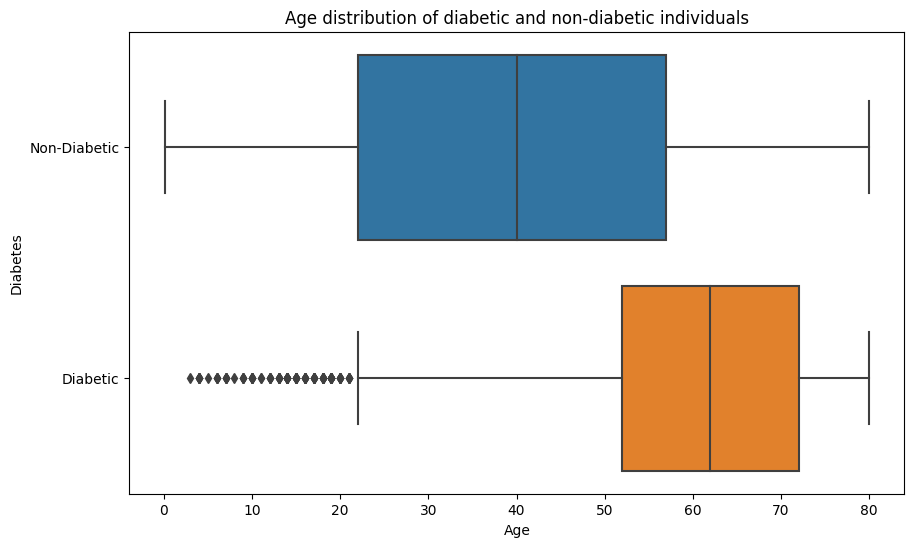

In [18]:
df['diabetes'] = df['diabetes'].astype('category')
plt.figure(figsize = (10, 6))
sns.boxplot(data = df, y = 'diabetes', x = 'age')
plt.title('Age distribution of diabetic and non-diabetic individuals')
plt.ylabel('Diabetes')
plt.yticks(ticks = [0, 1], labels = ['Non-Diabetic', 'Diabetic'])
plt.xlabel('Age')
plt.show()

From the boxplot above, the average age of non-diabetic individual is around 40 years of agee while that of diabetic individual is around 62 years of age. The age distribution of the individuals without diabetes is approximately normally distributed, whilst those with diabetes is skewed to the left.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


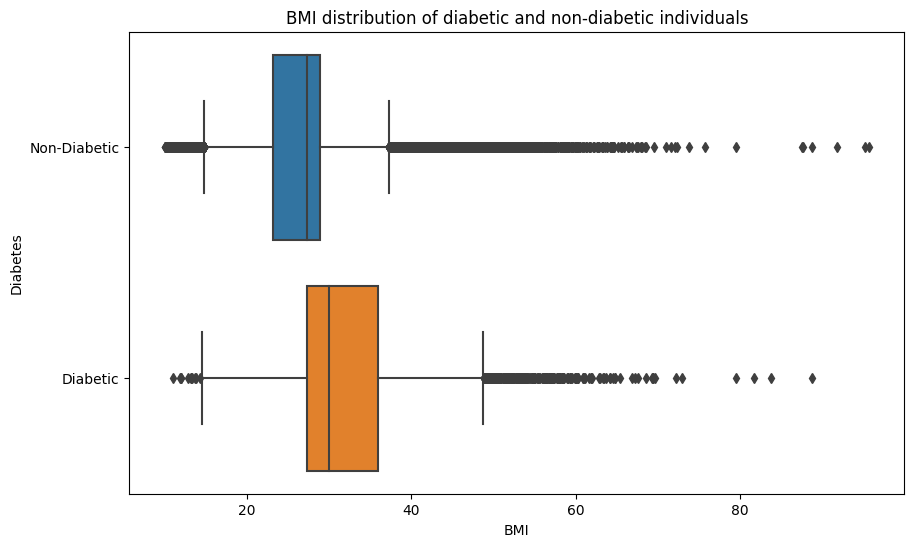

In [19]:
plt.figure(figsize = (10, 6))
sns.boxplot(data = df, y = 'diabetes', x = 'bmi')
plt.title('BMI distribution of diabetic and non-diabetic individuals')
plt.ylabel('Diabetes')
plt.yticks(ticks = [0, 1], labels = ['Non-Diabetic', 'Diabetic'])
plt.xlabel('BMI')
plt.show()

The distributions of the BMI of both individuals living with diabetes is rightly skewed due to the presence of extreme BMI values in the dataset suggesting there are many obesed individuals recorded int the data set. The average BMI of individuals with diabetes is lesser than those with diabetes

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


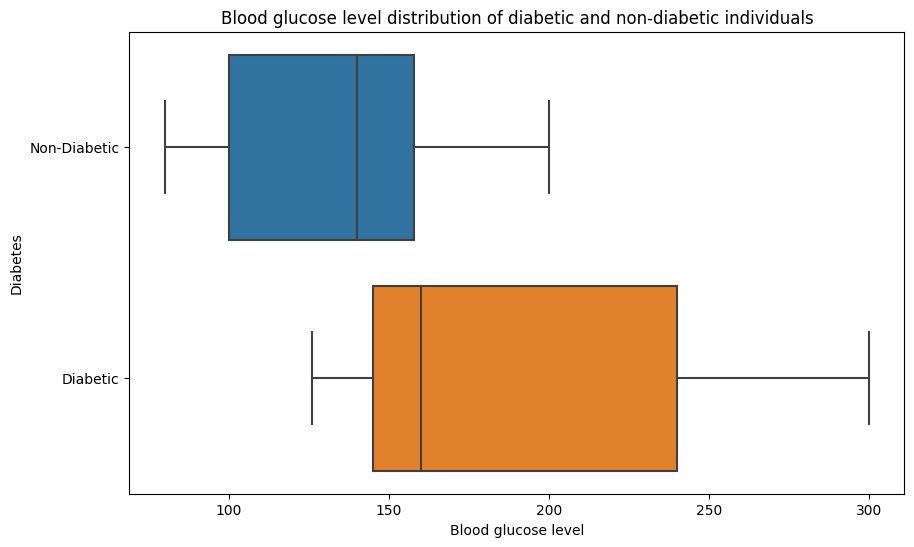

In [20]:
plt.figure(figsize = (10, 6))
sns.boxplot(data = df, y = 'diabetes', x = 'blood_glucose_level')
plt.title('Blood glucose level distribution of diabetic and non-diabetic individuals')
plt.ylabel('Diabetes')
plt.yticks(ticks = [0, 1], labels = ['Non-Diabetic', 'Diabetic'])
plt.xlabel('Blood glucose level')
plt.show()

The blood glucose level of individuals with diabetes ranges from approximately 60mg/dl to 200mg/dl while those with diabetes ranges between 130mg/dl to 300mg/dl. This is expected because high blood glucose level is one of the major manifestation or sypmtom of diabetes. 

The average blood glucose level of people without diabetes is a little below 150mg/dl and those with diabetes is around 160mg/dl

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


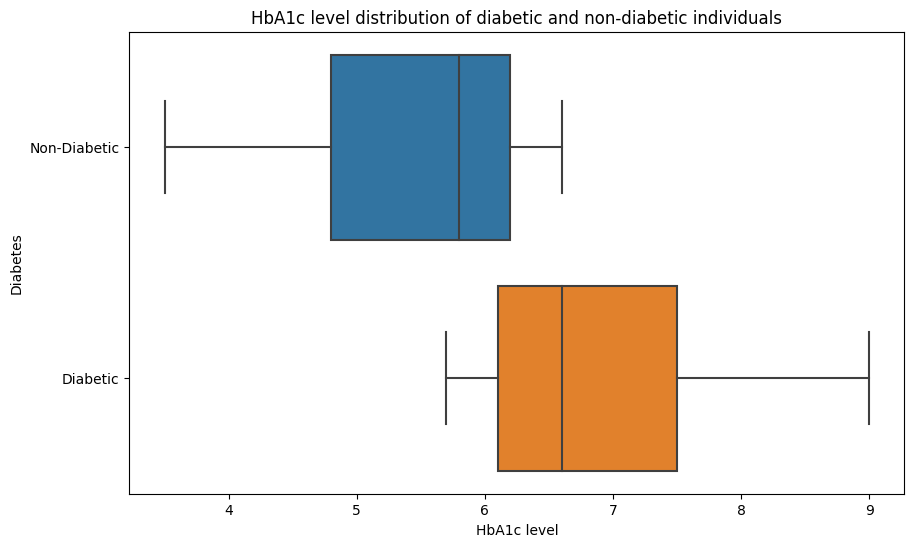

In [21]:
plt.figure(figsize = (10, 6))
sns.boxplot(data = df, y = 'diabetes', x = 'hbA1c_level')
plt.title('HbA1c level distribution of diabetic and non-diabetic individuals')
plt.ylabel('Diabetes')
plt.yticks(ticks = [0, 1], labels = ['Non-Diabetic', 'Diabetic'])
plt.xlabel('HbA1c level')
plt.show()

HbA1c level of individuals with diabetes ranges between 2 to 6.6 while that of those without is from 5.8 to 9. This is equally expected as increased level of HbA1c is closely associated with diabetes. The average HbA1c level of the former category is 5.8 while that of the later 6.7

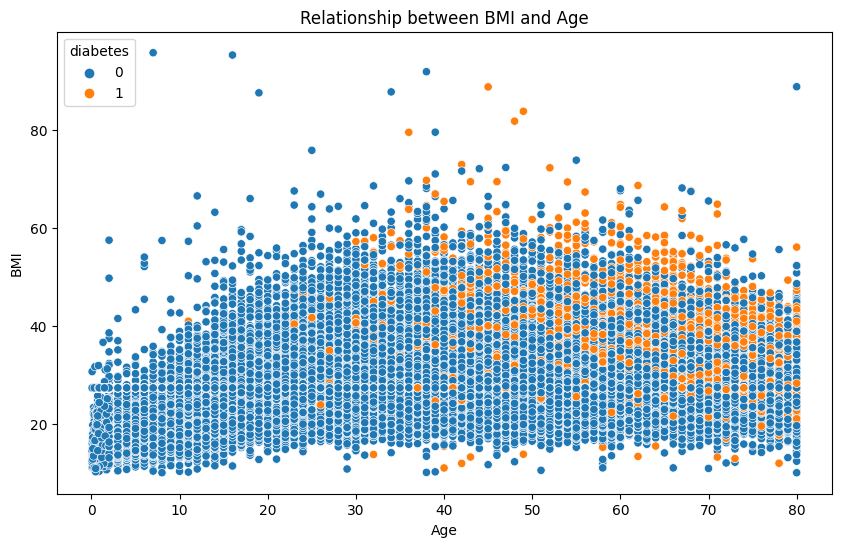

In [22]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = df, x = 'age', y = 'bmi', hue = 'diabetes')
plt.title('Relationship between BMI and Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

From the scatter plot above, we can see that more diabetes cases show up as age and BMI increases.

## Feature Engineering 

Used 'LabelEncoder()' to transform categorical variables like 'gender' and 'smoking_history' into numerical variables.

In [23]:
encoder = LabelEncoder()
df['gender'] = encoder.fit_transform(df['gender'])

In [24]:
df['smoking_history'] = encoder.fit_transform(df['smoking_history'])
df

,year,gender,age,location,AfricanAmerican,Asian,Caucasian,Hispanic,Others,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,0,32.0,Alabama,0,0,0,0,1,0,0,4,27.32,5.0,100,0
1,2015,0,29.0,Alabama,0,1,0,0,0,0,0,4,19.95,5.0,90,0
2,2015,1,18.0,Alabama,0,0,0,0,1,0,0,4,23.76,4.8,160,0
3,2015,1,41.0,Alabama,0,0,1,0,0,0,0,4,27.32,4.0,159,0
4,2016,0,52.0,Alabama,1,0,0,0,0,0,0,4,23.75,6.5,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,0,33.0,Wyoming,0,0,0,0,1,0,0,4,21.21,6.5,90,0
99996,2016,0,80.0,Wyoming,0,1,0,0,0,0,0,0,36.66,5.7,100,0
99997,2018,1,46.0,Wyoming,0,1,0,0,0,0,0,2,36.12,6.2,158,0
99998,2018,0,51.0,Wyoming,1,0,0,0,0,0,0,5,29.29,6.0,155,0


In [25]:
df.drop(columns = ['year', 'location'], axis = 1, inplace = True)
df

,gender,age,AfricanAmerican,Asian,Caucasian,Hispanic,Others,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,0,32.0,0,0,0,0,1,0,0,4,27.32,5.0,100,0
1,0,29.0,0,1,0,0,0,0,0,4,19.95,5.0,90,0
2,1,18.0,0,0,0,0,1,0,0,4,23.76,4.8,160,0
3,1,41.0,0,0,1,0,0,0,0,4,27.32,4.0,159,0
4,0,52.0,1,0,0,0,0,0,0,4,23.75,6.5,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,33.0,0,0,0,0,1,0,0,4,21.21,6.5,90,0
99996,0,80.0,0,1,0,0,0,0,0,0,36.66,5.7,100,0
99997,1,46.0,0,1,0,0,0,0,0,2,36.12,6.2,158,0
99998,0,51.0,1,0,0,0,0,0,0,5,29.29,6.0,155,0


Dropped unecessary columns which do not contribute to the predictability of the models

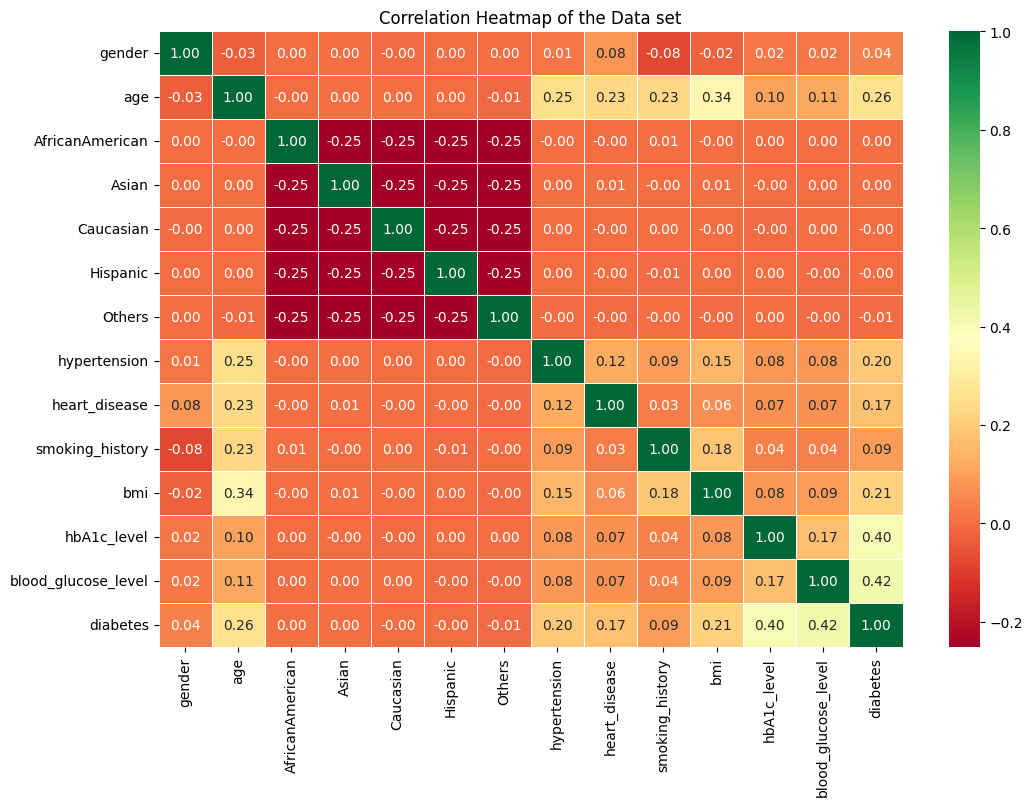

In [26]:
corr = df.corr()

plt.figure(figsize = (12, 8))
sns.heatmap(corr, annot = True, cmap = 'RdYlGn', fmt = '.2f', linewidths = 0.5)
plt.title('Correlation Heatmap of the Data set')
plt.show()

The heatmap shows us which variable is correlated with Diabetes and the strength of this relationship

## Modeling

In [27]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-8.41008617e-01, -4.39056670e-01, -5.03494963e-01, ...,
        -1.15591769e-04, -4.92698738e-01, -9.34928891e-01],
       [-8.41008617e-01, -5.72293503e-01, -5.03494963e-01, ...,
        -1.11052111e+00, -4.92698738e-01, -1.18057806e+00],
       [ 1.18728719e+00, -1.06082856e+00, -5.03494963e-01, ...,
        -5.36485150e-01, -6.79497979e-01,  5.38966101e-01],
       ...,
       [ 1.18728719e+00,  1.82715218e-01, -5.03494963e-01, ...,
         1.32574174e+00,  6.28096707e-01,  4.89836268e-01],
       [-8.41008617e-01,  4.04776607e-01,  1.98611719e+00, ...,
         2.96695653e-01,  4.41297466e-01,  4.16141518e-01],
       [ 1.18728719e+00, -1.28288995e+00, -5.03494963e-01, ...,
        -1.53087815e+00, -4.92698738e-01, -1.18057806e+00]])

In [29]:
print(X.shape, y.shape)

(99986, 13) (99986, 1)


In [30]:
y = y.to_numpy()
y = y.reshape(-1,)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, test_size = 0.3, random_state = rs)
print(f'The size of X_train is {X_train.shape}')
print(f'The size of y_train is {y_train.shape}')

The size of X_train is (69990, 13)
The size of y_train is (69990,)


A user defined function to calculate the accuracy of the models with.

In [32]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

### Baseline model - Logistic Regression

In [33]:
lr_model = LogisticRegression(random_state = rs).fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [34]:
evaluate_metrics(y_test, y_pred)

{'accuracy': 0.9602280304040539,
 'recall': array([0.99114625, 0.62745098]),
 'precision': array([0.96625582, 0.86814976]),
 'f1score': array([0.97854278, 0.7284316 ])}

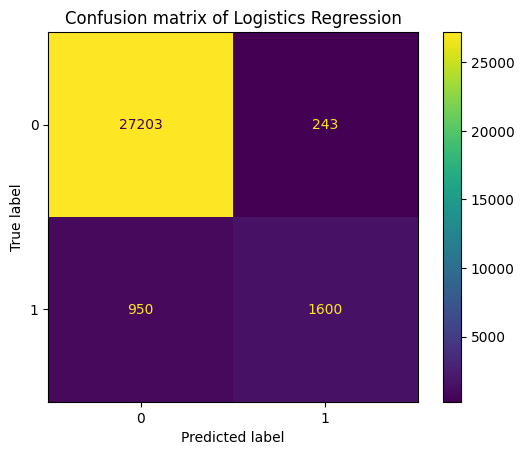

In [35]:
cf = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = lr_model.classes_)
cmd.plot()
plt.title('Confusion matrix of Logistics Regression')
plt.show()

Logistic regression model performed considerably well for a baseline model with 96% overall accuracy. The recall for class 0 (individuals without diabetes) is 99% and 62% for class 1, 97% precision for class 0 and 86% for class 1.

This is mostly due to data the data being unbalanced with 8.5% of the records being positive outcomes and 91.5% being negative outcomes, and can affect the generalisabilty of our models. To fix this, i tried assigning weights to the classes.

In [36]:
class_weight = {}
class_weight[0] = 0.085
class_weight[1] = 0.915

balanced_model = LogisticRegression(random_state = rs, class_weight = class_weight)
balanced_model.fit(X_train, y_train)

y_pred = balanced_model.predict(X_test)
evaluate_metrics(y_test, y_pred)

{'accuracy': 0.886051473529804,
 'recall': array([0.88730598, 0.87254902]),
 'precision': array([0.98683038, 0.41839037]),
 'f1score': array([0.9344256, 0.5655821])}

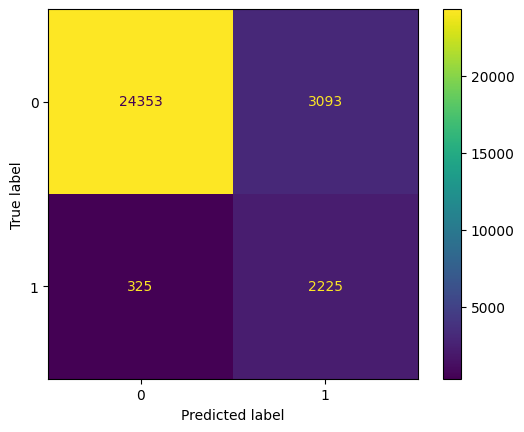

In [37]:
cf = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = balanced_model.classes_)
cmd.plot()
plt.show()

From the metrics above, you can see that assigning weights to the class do not improve the model

### Optimal Classifiers

1. Random Forest Classifier

In [38]:
max_features = round(np.sqrt(X.shape[1]) - 1)
n_estimators = 10

Rf_model = RandomForestClassifier(max_features = max_features, n_estimators = n_estimators, random_state = rs)
Rf_model.fit(X_train, y_train)
y_pred = Rf_model.predict(X_test)

evaluate_metrics(y_test, y_pred)

{'accuracy': 0.9704293905854113,
 'recall': array([0.9966844 , 0.68784314]),
 'precision': array([0.97172392, 0.95067751]),
 'f1score': array([0.9840459 , 0.79817975])}

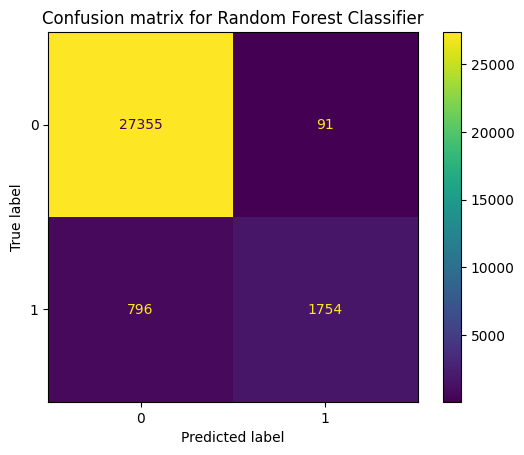

In [39]:
cf = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = Rf_model.classes_)
cmd.plot()
plt.title('Confusion matrix for Random Forest Classifier')
plt.show()

Random Forest performed significantly better than our baseline model

2. SVC

In [40]:
svc = SVC(kernel = 'rbf', C = 10)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

evaluate_metrics(y_test, y_pred)

{'accuracy': 0.9635951460194693,
 'recall': array([0.9980325 , 0.59294118]),
 'precision': array([0.96348927, 0.96551724]),
 'f1score': array([0.98045673, 0.73469388])}

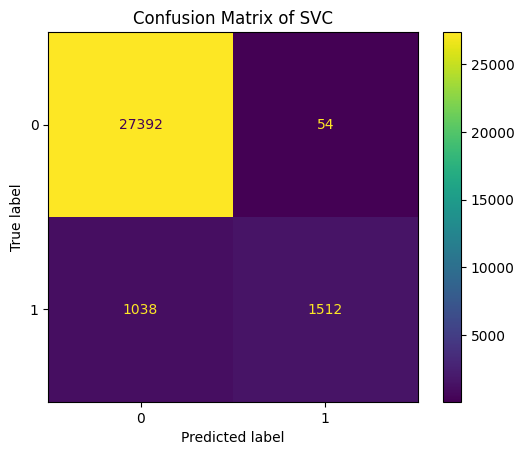

In [41]:
cf = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = svc.classes_)
cmd.plot()
plt.title('Confusion Matrix of SVC')
plt.show()

Support Vector did slightly better than the baseline model especially in reducing the false positive rate but it didn't come without a price

3. Gradient Boosting classifier

In [42]:
gbc = GradientBoostingClassifier(n_estimators = 10, random_state = rs)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

evaluate_metrics(y_test, y_pred)

{'accuracy': 0.9714628617148953,
 'recall': array([1.        , 0.66431373]),
 'precision': array([0.96975479, 1.        ]),
 'f1score': array([0.98464519, 0.79830349])}

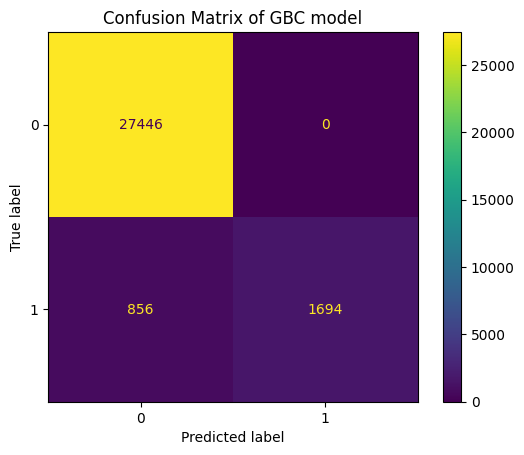

In [43]:
cf = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = svc.classes_)
cmd.plot()
plt.title('Confusion Matrix of GBC model')
plt.show()

GBC performs best on this data set with false positive rate reduced to 0